In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint

In [4]:
from Detection.RetinaNetEIPHFocalLoss import RetinaNetEIPHFocalLoss

In [5]:
from Detection.RetinaNetEIPH import RetinaNetEIPH
from Detection.RetinaNetEIPHFocalLoss import RetinaNetEIPHFocalLoss
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.helper.wsi_loader import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric, PascalVOCMetricByDistance

In [6]:
path = Path('../../Slides/Equine/')

database = Database()
database.open(str(path/'EIPH.sqlite'))

size = 512

In [7]:
files = []
lbl_bbox = []

getslides = """SELECT uid, filename FROM Slides"""
for currslide, filename in tqdm(database.execute(getslides).fetchall()):
    database.loadIntoMemory(currslide)

    check = True if 'erliner' in filename else False
    slidetype = 'Berliner Blau/' if check else 'Turnbull Blue/'

    slide_path = path / slidetype / filename

    slide = openslide.open_slide(str(slide_path))
    level = 1#slide.level_count - 1
    level_dimension = slide.level_dimensions[level]
    down_factor = slide.level_downsamples[level]

    classes = {3: 1, 4: 2, 5: 3, 6: 4, 7: 5}
    labels, bboxes = [], []
    for id, annotation in database.annotations.items():
        if annotation.labels[0].classId in classes:
            d = 2 * annotation.r / down_factor
            x_min = (annotation.x1 - annotation.r) / down_factor
            y_min = (annotation.y1 - annotation.r) / down_factor
            x_max = x_min + d
            y_max = y_min + d
            label = classes[annotation.labels[0].classId]

            bboxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
            labels.append(label)

    if len(bboxes) > 0:
        lbl_bbox.append([bboxes, labels])
        files.append(SlideContainer(slide_path, level, size, size))

  0%|          | 0/24 [00:00<?, ?it/s]

Loading DB into memory ...


  4%|▍         | 1/24 [00:00<00:06,  3.35it/s]

Loading DB into memory ...


  8%|▊         | 2/24 [00:01<00:17,  1.22it/s]

Loading DB into memory ...


 12%|█▎        | 3/24 [00:02<00:14,  1.40it/s]

Loading DB into memory ...


 21%|██        | 5/24 [00:02<00:10,  1.84it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 33%|███▎      | 8/24 [00:03<00:06,  2.40it/s]

Loading DB into memory ...
Loading DB into memory ...


 46%|████▌     | 11/24 [00:03<00:04,  2.99it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 50%|█████     | 12/24 [00:03<00:03,  3.01it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 71%|███████   | 17/24 [00:04<00:01,  3.55it/s]

Loading DB into memory ...
Loading DB into memory ...


 79%|███████▉  | 19/24 [00:04<00:01,  3.83it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 88%|████████▊ | 21/24 [00:05<00:00,  3.77it/s]

Loading DB into memory ...
Loading DB into memory ...


100%|██████████| 24/24 [00:06<00:00,  3.65it/s]

Loading DB into memory ...


In [8]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

In [9]:
bs = 32
train_images = 5000
val_images = 500

train_files = list(np.random.choice(files[4:], train_images))
valid_files = list(np.random.choice(files[:4], val_images))

#train_files = list(np.random.choice(files, train_images))
#valid_files = list(np.random.choice(files, val_images))

In [10]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-90, 90)}, p=0.5, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [11]:
train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min).normalize()

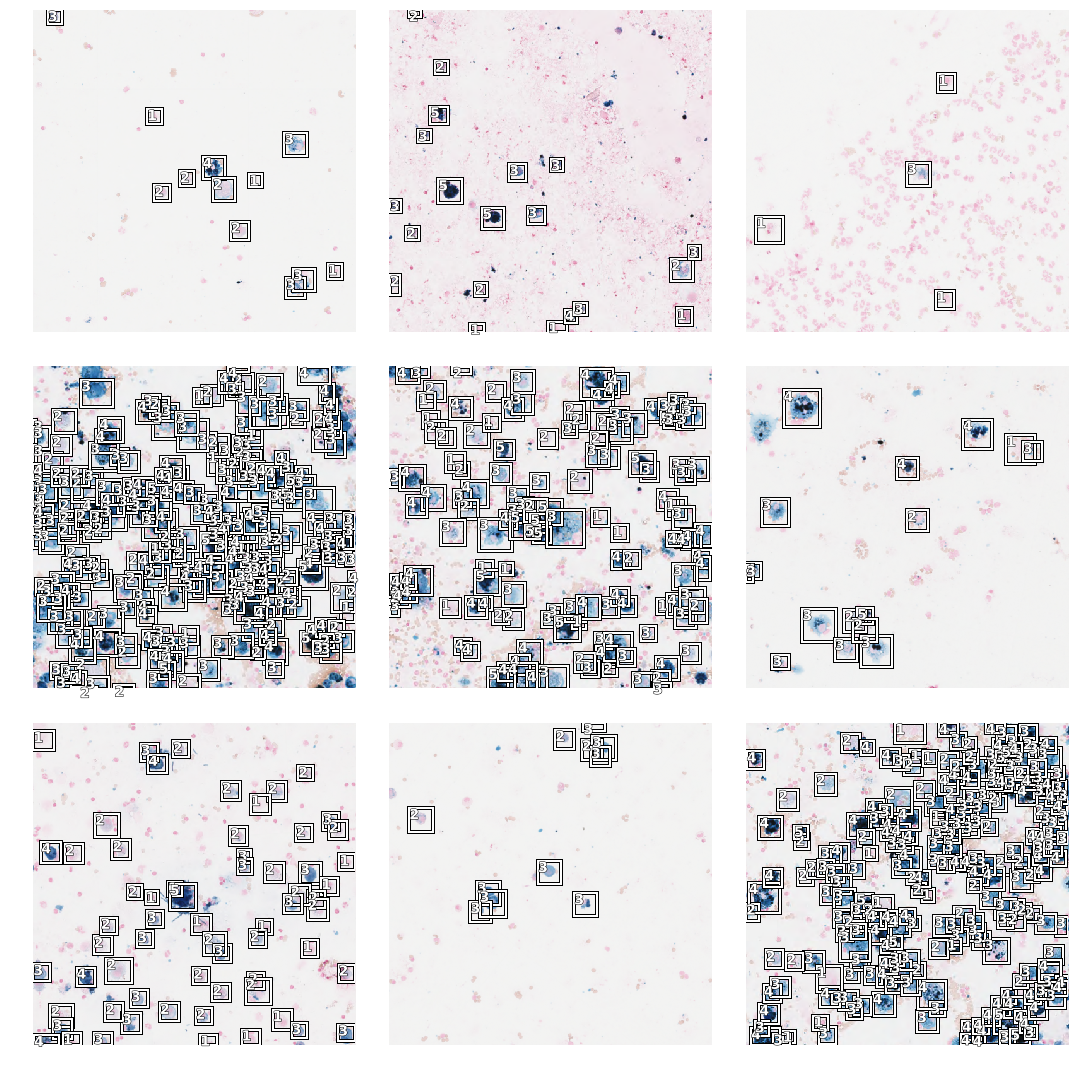

In [11]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(15,15))

In [12]:
anchors_32 = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.35, 0.5, 0.6])

In [13]:
anchors = anchors_32

In [137]:
anchors.shape

torch.Size([768, 4])

In [14]:
anchors

tensor([[-0.9688, -0.9688,  0.0875,  0.0875],
        [-0.9688, -0.9688,  0.1250,  0.1250],
        [-0.9688, -0.9688,  0.1500,  0.1500],
        ...,
        [ 0.9688,  0.9688,  0.0875,  0.0875],
        [ 0.9688,  0.9688,  0.1250,  0.1250],
        [ 0.9688,  0.9688,  0.1500,  0.1500]])

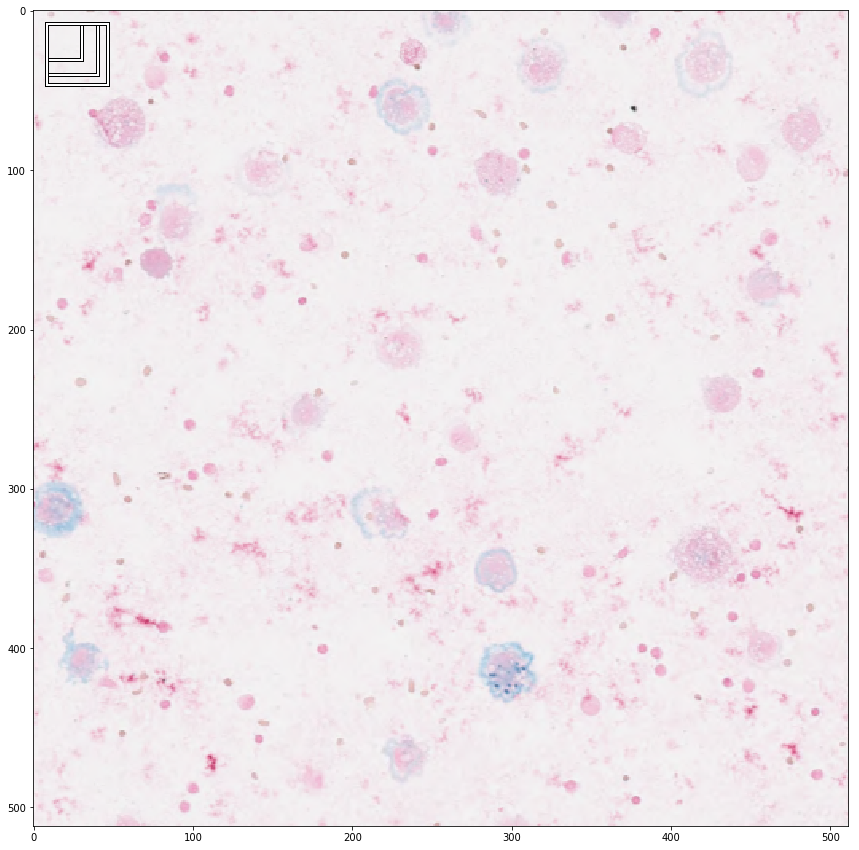

In [45]:
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:3]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [14]:
crit = RetinaNetEIPHFocalLoss(anchors, reg_loss_score=nn.MSELoss())

In [15]:
encoder = create_body(models.resnet50, True, -2)
model = RetinaNetEIPH(encoder, n_classes=data.train_ds.c, n_anchors=3, sizes=[32], chs=128, final_bias=-4., n_conv=3)

In [15]:
model

RetinaNetEIPH(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [16]:
voc = PascalVOCMetric(anchors, size, [str(i-1) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics],
                metrics=[voc])

In [17]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


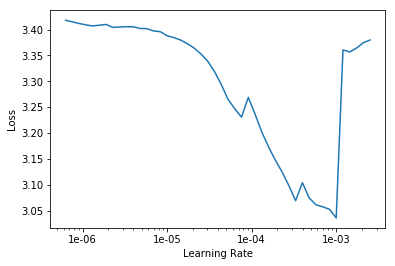

In [24]:
learn.lr_find()
learn.recorder.plot()

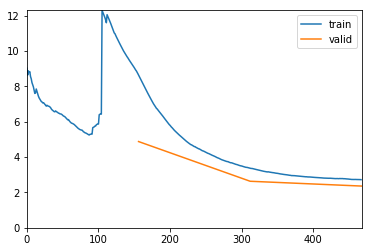

In [18]:
learn.fit_one_cycle(3, 1e-3)

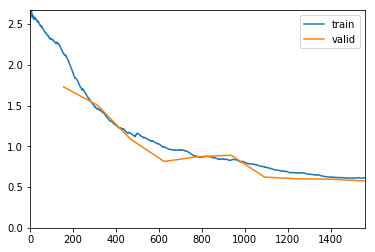

In [19]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)
#learn.save("pferd_512_1")

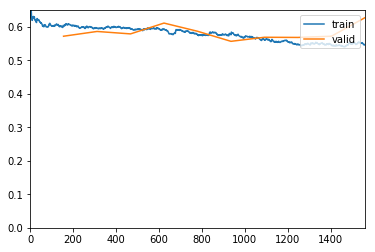

In [20]:
learn.fit_one_cycle(10, 1e-4)

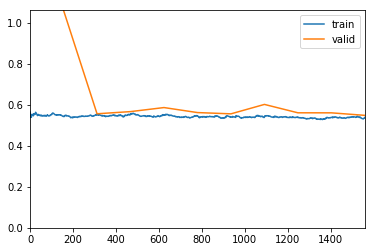

In [21]:
learn.fit_one_cycle(10, 1e-5)

In [24]:
learn.save("pferd_2_512_reg-50")

In [49]:
#learn.save("pferd_1_512")
learn.export("pferd_1_512")

In [200]:
classes = data.train_ds.classes

In [201]:
classes

['background', 1, 2, 3, 4, 5]

In [35]:
from data_loader import *

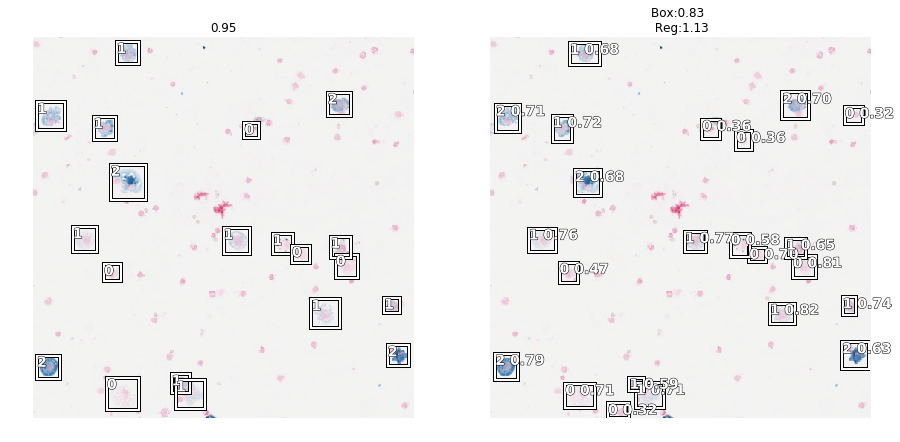

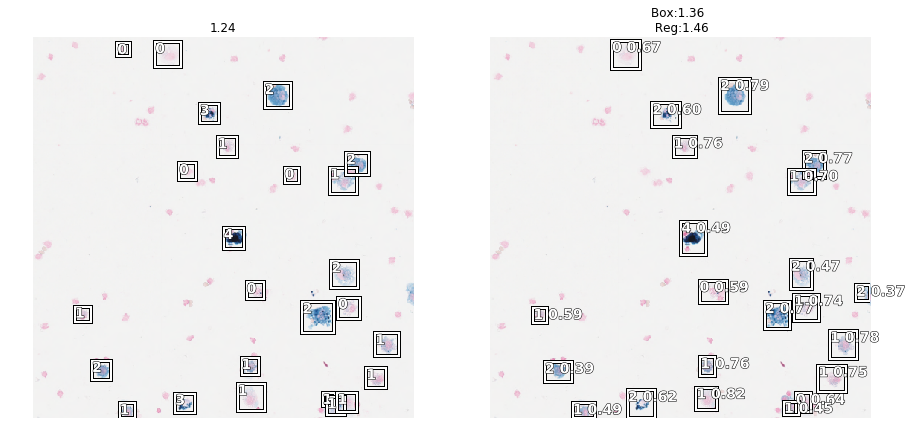

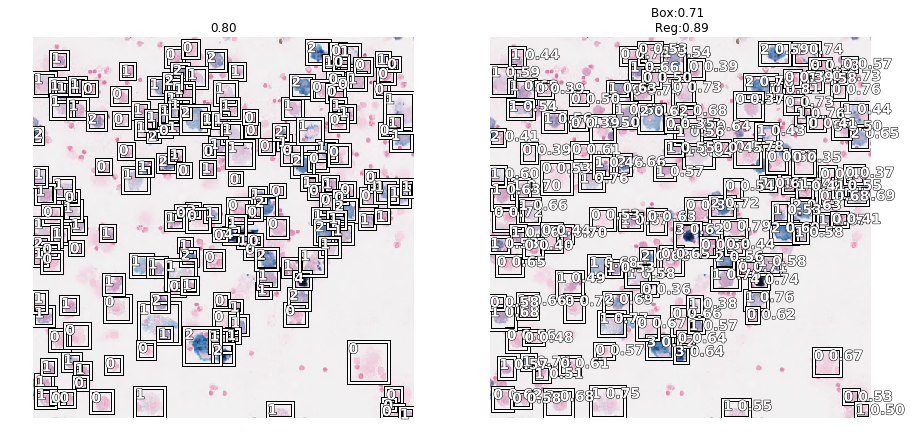

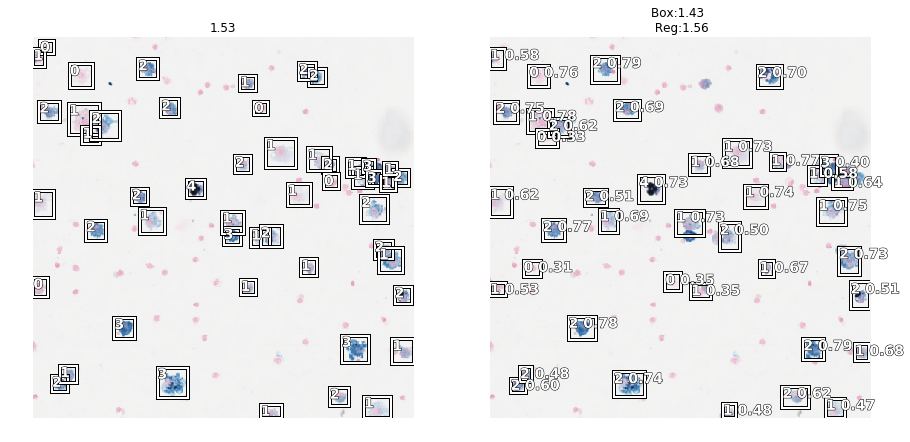

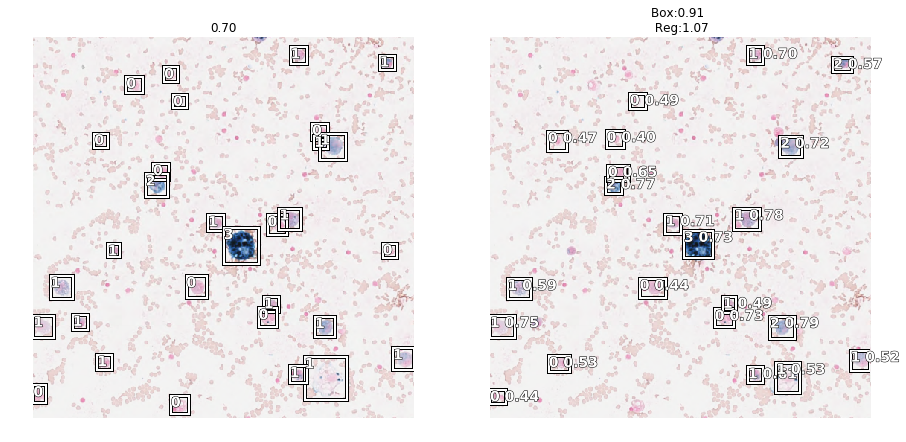

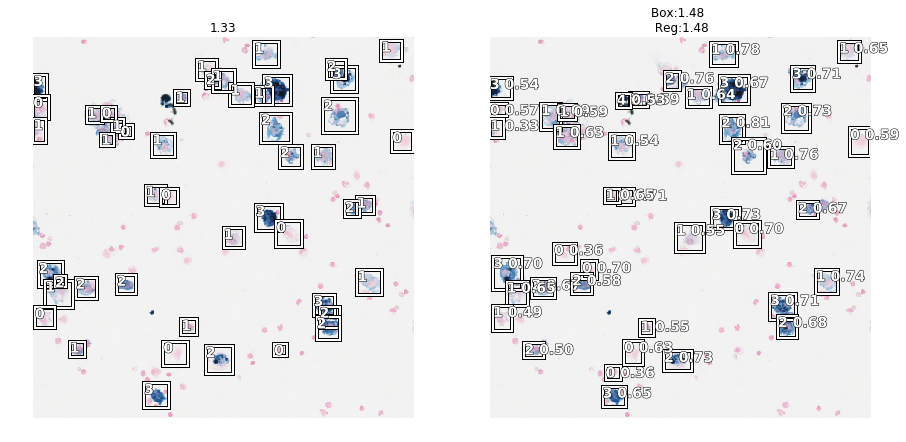

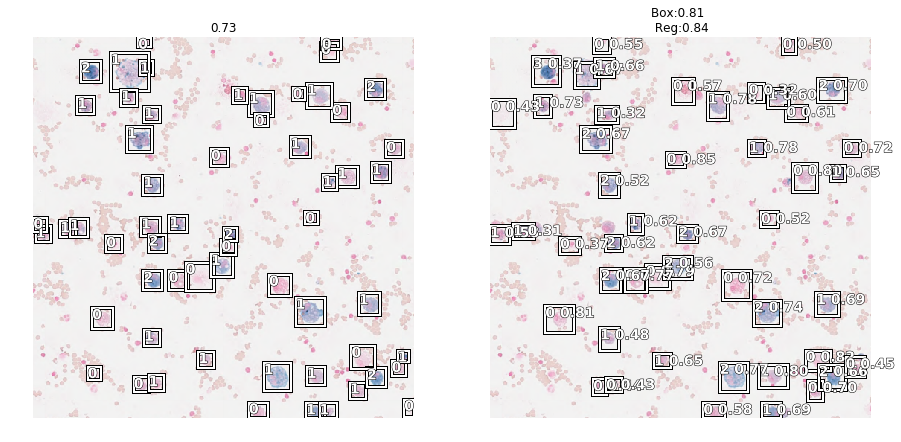

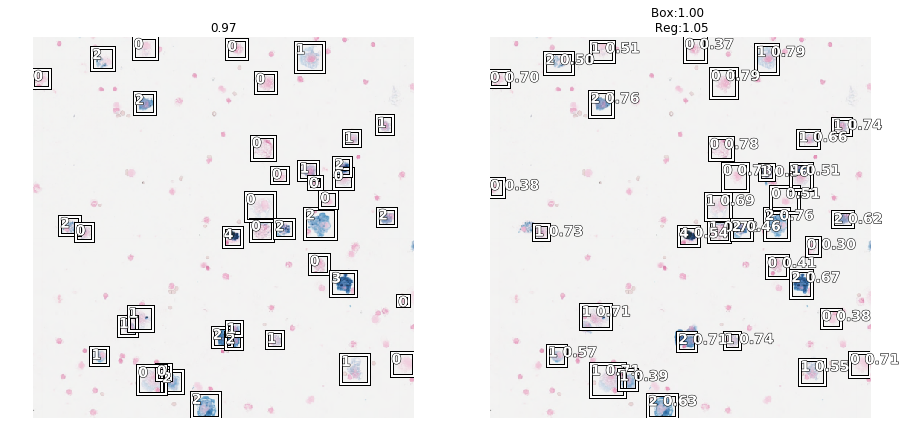

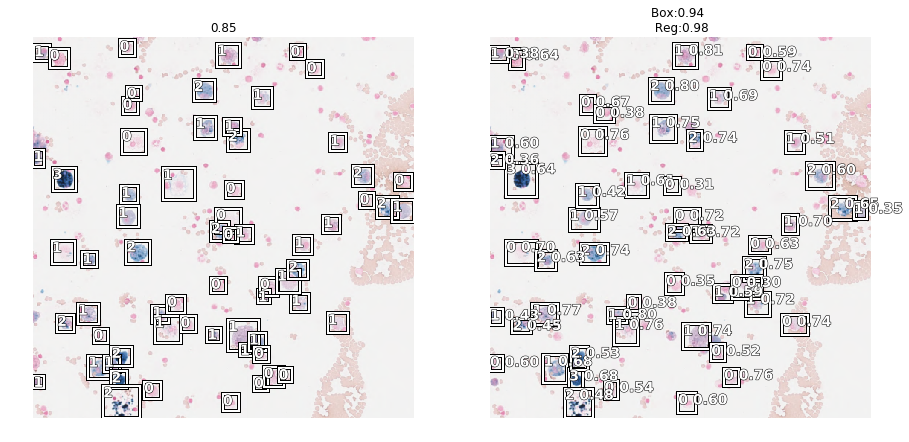

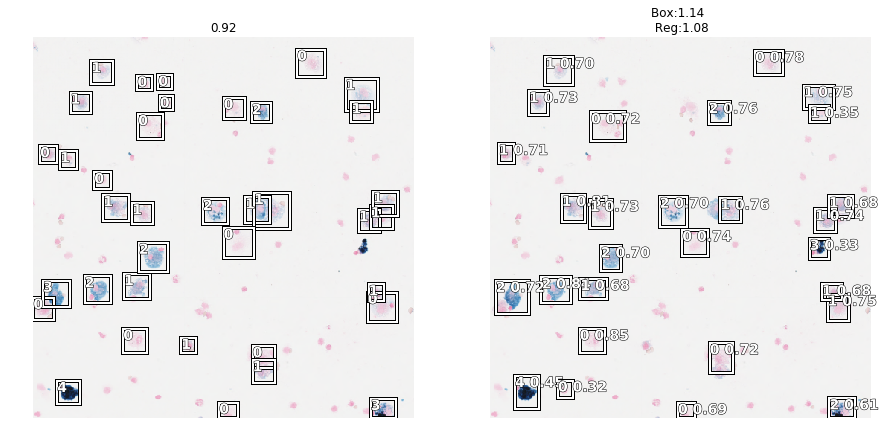

In [23]:
slide_object_result(learn, anchors, image_count=10, detect_thresh=0.3, nms_thresh=0.1)